In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from scipy import misc
directory = "../annotations/deathCircle/video0/"
# A boolean matrix encoding the location of streets
from scipy.signal import decimate,fftconvolve,gaussian
q=5 #downsampline rate
reader = lambda fname : (misc.imread(directory+fname)).min(axis=2) == 0
decimater = lambda x: decimate( decimate( x , q , axis=0), q, axis=1)
sigma = 20
N_g=30
G = gaussian(N_g,sigma) / (N_g*np.sqrt(2*np.pi*sigma**2))
kernel = np.outer( G, G)
smoother = lambda im : fftconvolve( im , kernel ,mode='valid')
street_downsampled = decimater( reader("street.bmp"))
street_smoothed = smoother( street_downsampled)
street_fourier = np.fft.fftn(street_smoothed)

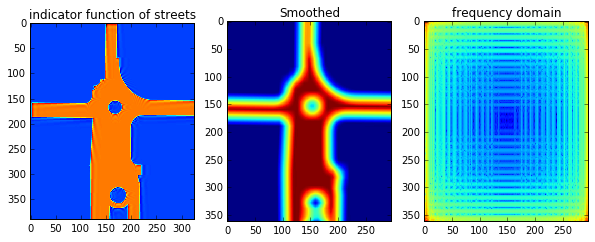

In [3]:
f, (ax0,ax1,ax2) = plt.subplots(1,3)
ax0.imshow(street_downsampled,interpolation='nearest')
ax0.set_title('indicator function of streets')
ax1.imshow(street_smoothed, interpolation='nearest')
ax1.set_title('Smoothed')
ax2.imshow(np.log(np.abs(street_fourier)))
ax2.set_title('frequency domain')
f.set_size_inches((10,10))

#FFT conventions in numpy
The numpy implementation of the 2-dimensional FFT is
\begin{align*}
A_{kl} =  \sum_{m=0}^{M-1} \sum_{n=0}^{N-1}
a_{mn}\exp\left\{-2\pi i \left({mk\over M}+{nl\over N}\right)\right\}
\qquad k = 0, \ldots, M-1;\quad l = 0, \ldots, N-1,
\end{align*}
The inverse transformation is given by
\begin{align*}
a_{kl} =  \frac{1}{MN}\sum_{m=0}^{M-1} \sum_{n=0}^{N-1}
A_{mn}\exp\left\{2\pi i \left({mk\over M}+{nl\over N}\right)\right\}
\qquad k = 0, \ldots, M-1;\quad l = 0, \ldots, N-1,
\end{align*}

In [4]:
street_reconstructed = np.zeros( street_smoothed.shape, dtype='complex')
X_res = street_smoothed.shape[0]
Y_res = street_smoothed.shape[1]
x_span = np.arange(0,X_res)/float(X_res)
y_span = np.arange(0,Y_res)/float(Y_res)
X_mesh,Y_mesh = np.meshgrid( x_span, y_span )
Nx = 20
Ny = 20
for i in range(-Nx/2,Nx/2):
    for j in range(-Ny/2,Ny/2):
        street_reconstructed += np.exp( 2*np.pi*1j*(i*X_mesh.T+j*Y_mesh.T ) )*street_fourier[i,j]/(X_res*Y_res)

L2 error is 0.003000


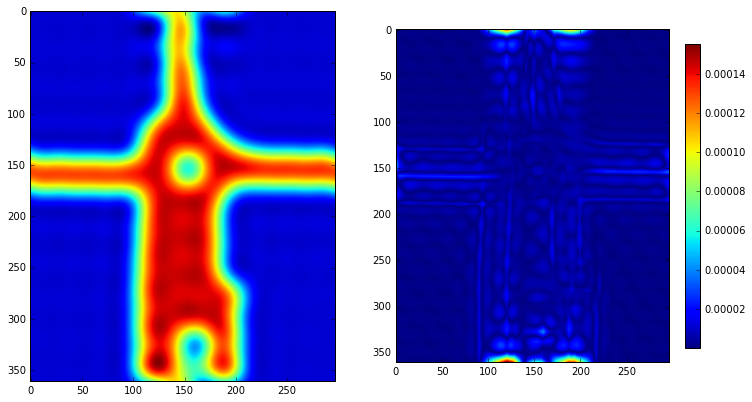

In [5]:
f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(street_reconstructed.real)
error_low_modes = np.abs(street_reconstructed - street_smoothed)
error_plot = ax2.imshow( error_low_modes )
f.colorbar(error_plot, fraction=0.05, pad=0.05)
f.set_size_inches((12,12))

print "L2 error is {:f}".format( np.linalg.norm(error_low_modes, ord='fro'))

## Getting the largest modes
Now let's extract the largest modes.

In [6]:
indices = [(i,j) for i in range(X_res) for j in range(Y_res)]
indices = sorted(indices, key=lambda ij:np.abs(street_fourier[ij]),reverse=True)
street_dropout = np.zeros(street_smoothed.shape, dtype='complex')
for ij in indices[0:Nx*Ny]:
    street_dropout += street_fourier[ij]*np.exp( 2*np.pi*1j*(ij[0]*X_mesh.T+ij[1]*Y_mesh.T ) ) / float(X_res*Y_res)

L2 error is 0.002313


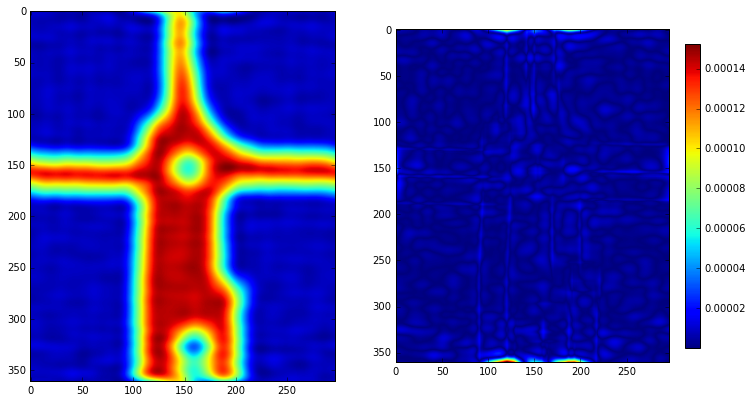

In [7]:
f,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(street_dropout.real)
error = np.abs(street_dropout - street_smoothed)
error_plot = ax2.imshow(error)
f.colorbar(error_plot, fraction=0.05, pad=0.05)
f.set_size_inches((12,12))

print "L2 error is {:f}".format( np.linalg.norm(error,ord='fro') )

#Results:
The improvement in the L2 norm is fairly modest.  But the picture looks a lot better.

#Constructing a potential function for street
Here is code to construct a potential function for grass

In [8]:
major_indices = indices[0:Nx*Ny]
major_coefs = [ street_fourier[ij] for ij in major_indices]
def potential_function_grass(x,y):
    global major_indices, major_coefs, X_res,Y_res
    if type(x)==type(1):
        out = 0.0 + 0.0*1j
    else:
        out = np.zeros( x.shape , dtype = 'complex')
    for ij in major_indices:
        i = ij[0]
        j = ij[1]
        out += street_fourier[i,j]*np.exp(2*np.pi*1j*(i*x + j*y) ) / float(X_res*Y_res)
    return out

In [9]:
Z = potential_function_grass(X_mesh.T,Y_mesh.T)

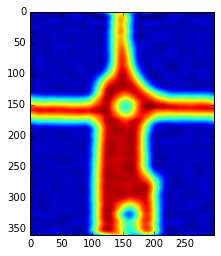

In [10]:
plt.imshow(Z.real)

Yay!  This looks correct.  I've now used these findings in `potential_funciton.py`.

# Testing potential_function.py

In [24]:
import potential_function
potential_function = reload( potential_function )
terrain_types = potential_function.terrain_types
sigmas = potential_function.sigmas
V = potential_function.V

In [26]:
theta = {t: {s: 0.0 for s in sigmas} for t in terrain_types}
theta["street"][sigmas[2]] = 1.0

In [ ]:
Z=V(X_mesh.T,Y_mesh.T, theta)

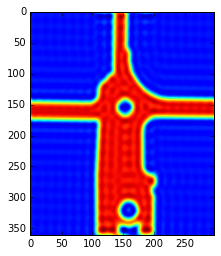

In [20]:
plt.imshow(Z)

In [25]:
import random
x=random.uniform(0,250)
y=random.uniform(0,350)
from time import time
t0 = time()
z = V(x,y,theta)
print "z={:f}, time={:f}".format(z, time()-t0)

z=0.000071, time=0.086268
